# STAT0032 Group 12 Task 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from scipy.stats import norm
import statsmodels.api as sm

## Importing data

In [2]:
# Import data
hour_data = pd.read_csv("data/hour.csv")
day_data = pd.read_csv("data/day.csv")

## Checks that '*day.csv*' can be constructed from  '*hour.csv*'

In [3]:
# Collapse hour data at the day level
hour_data_collapsed = hour_data.groupby(['dteday'])[['temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']].agg(['mean', 'sum']).reset_index()

# Clean index names
hour_data_collapsed.columns = hour_data_collapsed.columns.to_flat_index()
for i in range(1, len(hour_data_collapsed.columns)):
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i]:hour_data_collapsed.columns[i][0] + '_' + hour_data_collapsed.columns[i][1]}, axis=1)
hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[0] : 'dteday'}, axis=1)

# Keep only variables of interest and rename
hour_data_collapsed = hour_data_collapsed.drop(['temp_sum', 'atemp_sum', 'windspeed_sum', 'casual_mean', 'registered_mean', 'cnt_mean'], axis=1)

for i in range(1, len(hour_data_collapsed.columns)):
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i].removesuffix('_mean')}, axis=1)
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i].removesuffix('_sum')}, axis=1)
    hour_data_collapsed = hour_data_collapsed.rename({hour_data_collapsed.columns[i] : hour_data_collapsed.columns[i] + '_collapsed'}, axis=1)

# Merge collapsed hour data with day data
merged_data = pd.merge(day_data, hour_data_collapsed, on='dteday')
columns_to_check = ['temp', 'atemp', 'windspeed', 'casual', 'registered', 'cnt']
for c in columns_to_check:
    col = c + '_check'
    merged_data[col] = merged_data[c] - merged_data[c + '_collapsed']

# Assert checked versions are zero
for c in columns_to_check:
    col = c + '_check'
    assert merged_data[col].min() > -0.00001
    assert merged_data[col].max() < 0.00001

## Pre-processing

In [4]:
# Spring and summer only
peak_evenings = hour_data.copy()
peak_evenings = peak_evenings[peak_evenings.season.isin([1, 2])]

# Defining evening peak times
peak_evenings = peak_evenings[peak_evenings.workingday==1]
peak_evenings = peak_evenings[peak_evenings.hr.isin([16,17,18,19])]

## Histograms

In [5]:
# Collapse at the daily level
peak_evenings_daily = peak_evenings.copy()
peak_evenings_daily = peak_evenings_daily.groupby(['dteday', 'season'])[['cnt']].agg(['sum'])
peak_evenings_daily.columns=peak_evenings_daily.columns.droplevel(0)
peak_evenings_daily.reset_index(inplace=True)

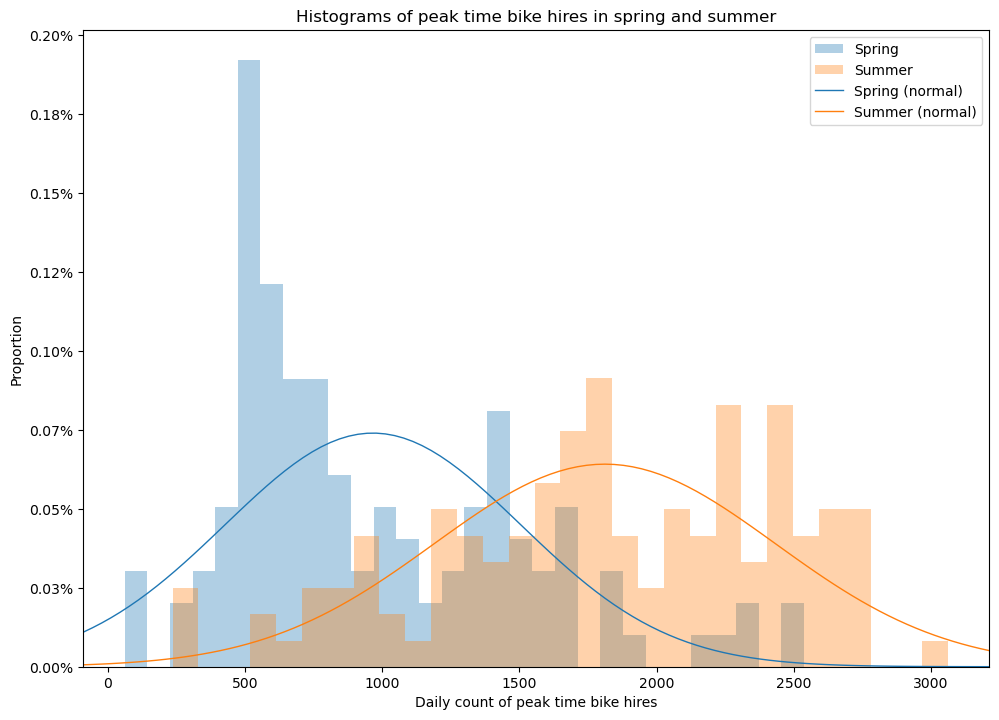

In [6]:
# Setup normal distributions
mu_spring, std_spring = norm.fit(peak_evenings_daily['sum'][peak_evenings_daily.season==1])
mu_summer, std_summer = norm.fit(peak_evenings_daily['sum'][peak_evenings_daily.season==2])

# Histogram plot
fig, ax = plt.subplots(figsize=(11.69,8.27))
ax.hist(peak_evenings_daily['sum'][peak_evenings_daily.season==1], alpha=0.35, density=True, bins=30, label='Spring')
ax.hist(peak_evenings_daily['sum'][peak_evenings_daily.season==2], alpha=0.35, density=True, bins=30, label='Summer')

# Plot the normal distributions
x_min, x_max = plt.xlim()
x = np.linspace(x_min, x_max, 100)
p_spring = norm.pdf(x, mu_spring, std_spring)
p_summer = norm.pdf(x, mu_summer, std_summer)
plt.plot(x, p_spring, 'C0', linewidth=1, label='Spring (normal)')
plt.plot(x, p_summer, 'C1', linewidth=1, label = 'Summer (normal)')

# Plotting setup
plt.margins(x=0)
ax.legend(loc = 'upper right')
ax.set_ylabel('Proportion')
ax.set_xlabel('Daily count of peak time bike hires')
ax.set_title('Histograms of peak time bike hires in spring and summer')
ax.yaxis.set_major_formatter(tick.PercentFormatter(xmax=1, decimals=2))
fig.savefig('plots/Peak times combined histograms.png')

The histogram above shows that neither of the two distributions appear to follow a normal distribution, nor do they seem to follow similar distributions.

## Q-Q Plots

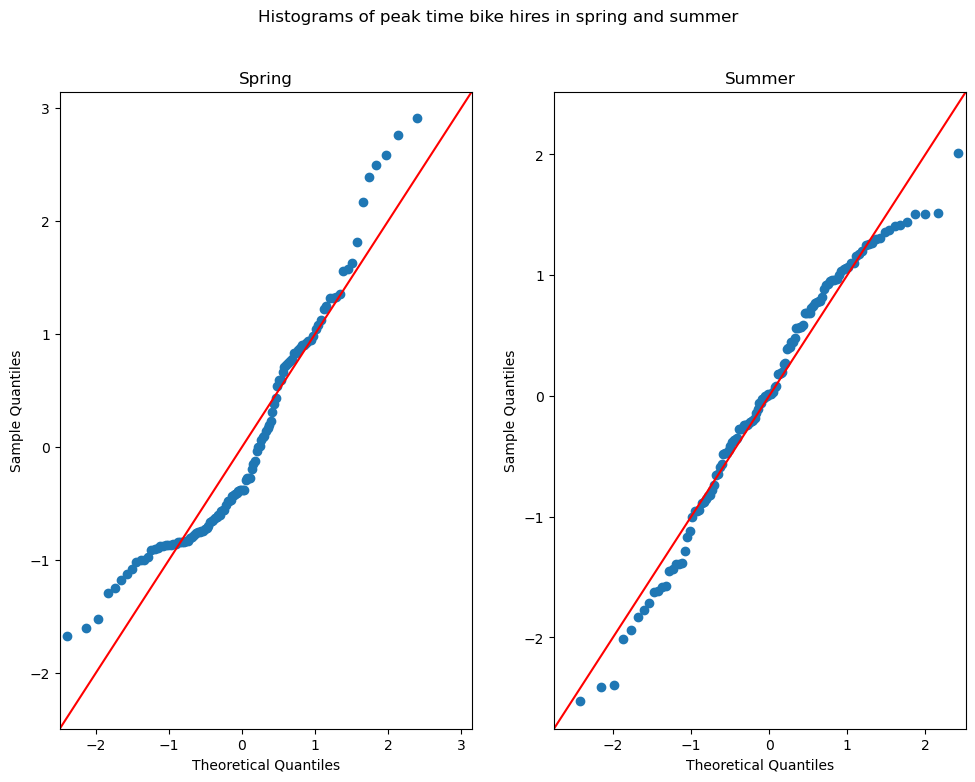

In [7]:
fig, (ax0, ax1)= plt.subplots(ncols=2, figsize=(11.69,8.27))
sm.qqplot(peak_evenings_daily['sum'][peak_evenings_daily.season==1], line='45', fit=True, ax = ax0)
ax0.set_title('Spring')
sm.qqplot(peak_evenings_daily['sum'][peak_evenings_daily.season==2], line='45', fit=True, ax = ax1)
ax1.set_title('Summer')
fig.suptitle('Histograms of peak time bike hires in spring and summer')
fig.savefig('plots/QQ plots.png')

## Statistical Tests
TO DO

## Sensitivities
TO DO